## Fraud Detection 

The purpose of this notebook is to attempt to detect fraud using XGBoost classifier, assess the model's performance, and finally, understand how the model is predicting fraud using feature importance.

In [1]:
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import BorderlineSMOTE 
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import shap

sys.path.append(os.path.abspath(os.path.join('..')))
from utilities.utils import (
    prep_data,
    plot_correlation_matrix,
    get_best_n_estimators,
    get_shap_values
)


/Users/erinknochenhauer/.local/share/virtualenvs/silent_eight-IOYIP5YF/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
trxns = pd.read_csv('../data/feature_engineering_output.csv')
trxns.shape

(5302, 26)

In [3]:
trxns.set_index(['customer', 'customer_country', 'counterparty','ccy', 'converted_time'], inplace=True)
trxns.head()

scaled_amount  \
customer        customer_country counterparty   ccy converted_time                       
C12976926337644 UK               77697395249488 JPY 2021-03-19 21:59:25      -0.186732   
                                                GBP 2021-05-01 19:00:38      -0.115031   
                                                USD 2021-05-23 14:15:15      -0.012516   
                                                CNY 2021-07-07 13:36:50      -0.038945   
                                                USD 2021-09-01 16:14:03      -0.010797   

                                                                         type_DIVIDEND  \
customer        customer_country counterparty   ccy converted_time                       
C12976926337644 UK               77697395249488 JPY 2021-03-19 21:59:25              0   
                                                GBP 2021-05-01 19:00:38              0   
                                                USD 2021-05-23 14:15:15              0   
                                                CNY 2021-07-07 13:36:50              0   
                                                USD 2021-09-01 16:14:03              0   

                                                                         type_INTEREST  \
customer        customer_country counterparty   ccy converted_time                       
C12976926337644 UK               77697395249488 JPY 2021-03-19 21:59:25              0   
                                                GBP 2021-05-01 19:00:38              0   
                                                USD 2021-05-23 14:15:15              0   
                                                CNY 2021-07-07 13:36:50              0   
                                                USD 2021-09-01 16:14:03              0   

                                                                         type_INVESTMENT  \
customer        customer_country counterparty   ccy converted_time                         
C12976926337644 UK               77697395249488 JPY 2021-03-19 21:59:25                0   
                                                GBP 2021-05-01 19:00:38                0   
                                                USD 2021-05-23 14:15:15                0   
                                                CNY 2021-07-07 13:36:50                0   
                                                USD 2021-09-01 16:14:03                0   

                                                                         type_OTHER  \
customer        customer_country counterparty   ccy converted_time                    
C12976926337644 UK               77697395249488 JPY 2021-03-19 21:59:25           1   
                                                GBP 2021-05-01 19:00:38           0   
                                                USD 2021-05-23 14:15:15           0   
                                                CNY 2021-07-07 13:36:50           0   
                                                USD 2021-09-01 16:14:03           0   

                                                                         type_PAYMENT  \
customer        customer_country counterparty   ccy converted_time                      
C12976926337644 UK               77697395249488 JPY 2021-03-19 21:59:25             0   
                                                GBP 2021-05-01 19:00:38             1   
                                                USD 2021-05-23 14:15:15             1   
                                                CNY 2021-07-07 13:36:50             1   
                                                USD 2021-09-01 16:14:03             1   

                                                                         type_TRANSFER  \
customer        customer_country counterparty   ccy converted_time                       
C12976926337644 UK               77697395249488 JPY 2021-03-19 21:59:25              0   
                               

### See if any variables are highly related

Avoid multicollinearity by dropping variables that are highly correlated.

In [4]:
plot_correlation_matrix(trxns.corr())

Looks like dropping variables is unneccessary based on the heatmap. It is slightly concerning that none of the variables individually are associated to the dependent variable.

### Deal with class imbalance

Since less than 2% of transactions are fraudulent in our dataset, the model could just choose to label all potential transactions as legitimate since it would be correct 98% of the time. We need to resample the dataset to avoid this issue. 

In [5]:
trxns.fraud_flag.value_counts()

0    5211
1      91
Name: fraud_flag, dtype: int64

In [6]:
X, y = prep_data(trxns)
print(X.shape)
print(y.shape)

(5302, 20)
(5302,)


In [7]:
# first split between training and testing sets since I don't want to include resampled records in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=48)


In [8]:
method = BorderlineSMOTE(random_state=44)
X_resampled, y_resampled = method.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_resampled))

Resampled dataset shape Counter({0: 4166, 1: 4166})


In [9]:
corr_matrix_resampled = pd.DataFrame(X_resampled, columns=list(trxns.columns)[:-1]).corr()

In [10]:
plot_correlation_matrix(corr_matrix_resampled)

### XGBoost for fraud detection

- First, run a grid search to see how many trees (n_estimators) would be best for the use case.
- Then, train the model on resampled training data and assess acuracy, precision and recall. 
- Finally, understand why the model is predicting fraud or not through feature importance at the individual level as well as aggregate level.

In [11]:
best_n_estimators = get_best_n_estimators(X_resampled, y_resampled)

Best: -0.028250 using {'n_estimators': 100}
-0.030145 (0.007716) with: {'n_estimators': 50}
-0.028250 (0.008989) with: {'n_estimators': 100}
-0.028471 (0.009738) with: {'n_estimators': 150}
-0.029072 (0.010030) with: {'n_estimators': 200}
-0.029572 (0.010464) with: {'n_estimators': 250}


In [12]:
method = XGBClassifier(
    n_estimators = best_n_estimators,
    importance_type = 'gain',
    random_state=42
)
xgb_model = method.fit(X_resampled, y_resampled)
# predict
xgb_y_predict = xgb_model.predict(X_test)
print(confusion_matrix(xgb_y_predict, y_test))
print(classification_report(xgb_y_predict, y_test))
# accuracy score
xgb_score = accuracy_score(xgb_y_predict, y_test)
print('Accuracy score is:', xgb_score)

[[1041    4]
 [   4   12]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       0.75      0.75      0.75        16

    accuracy                           0.99      1061
   macro avg       0.87      0.87      0.87      1061
weighted avg       0.99      0.99      0.99      1061

Accuracy score is: 0.9924599434495759


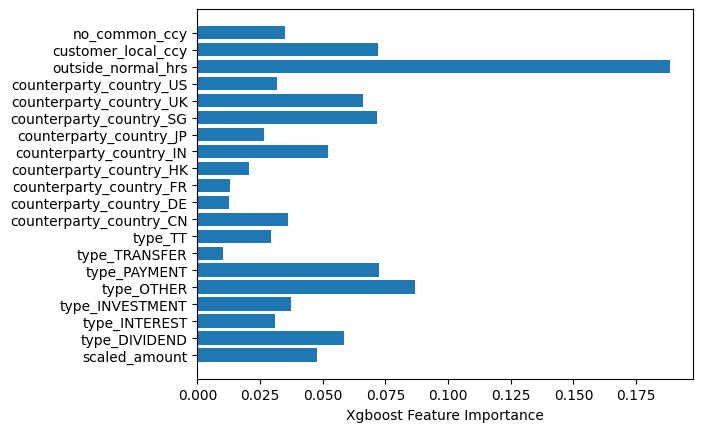

In [13]:
# understand which features are most important in identifying fraud with xgboost built in feature importances (using gain metric)
plt.barh(list(trxns.columns)[:-1], xgb_model.feature_importances_)
plt.xlabel("Xgboost Feature Importance")
plt.show()

### Shapley values from game theory

Features pushing the prediction higher (i.e. fraudulent) are shown in red, those pushing the prediction lower (not fraudulent) are in blue.

In [14]:
feature_names = list(trxns.columns)[:-1]
X = pd.DataFrame(X_test, columns=feature_names)

In [15]:
shap_values = get_shap_values(X, xgb_model)

/Users/erinknochenhauer/.local/share/virtualenvs/silent_eight-IOYIP5YF/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



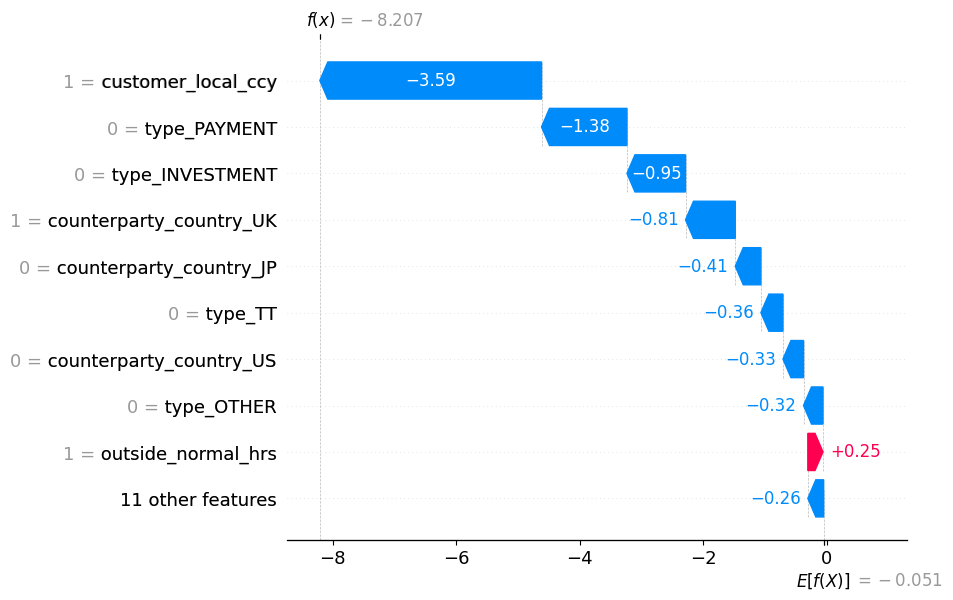

In [16]:
# waterfall plot for an individual observation interpretation
shap.plots.waterfall(shap_values[3])

In the graph above, we can see that having the transaction occur in the customer's local currency greatly decreases the likelihood of fraud. The fact that the transaction occurred outside normal hours (between midnight and 6 am) increased the liklihood of fraud. Overall, this transaction was not considered fraud given the impact of all features as a whole.

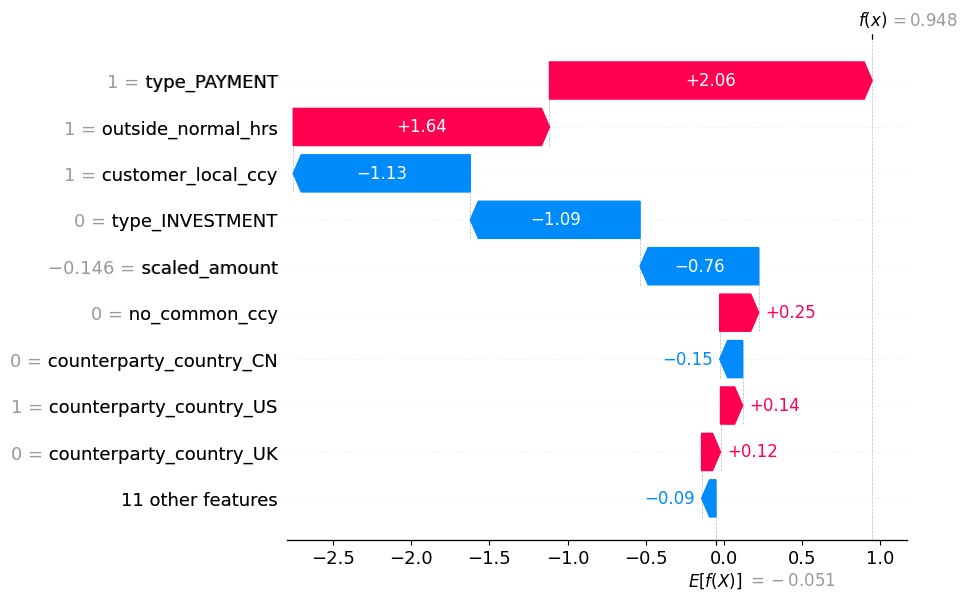

In [17]:
# waterfall plot for an individual observation interpretation - fraudulent transaction example
shap.plots.waterfall(shap_values[538])

The above transaction was predicted fraudulent mainly due to the transaction being labeled as Other and that it occurred outside normal hours. 

/Users/erinknochenhauer/.local/share/virtualenvs/silent_eight-IOYIP5YF/lib/python3.10/site-packages/shap/plots/_beeswarm.py:340: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



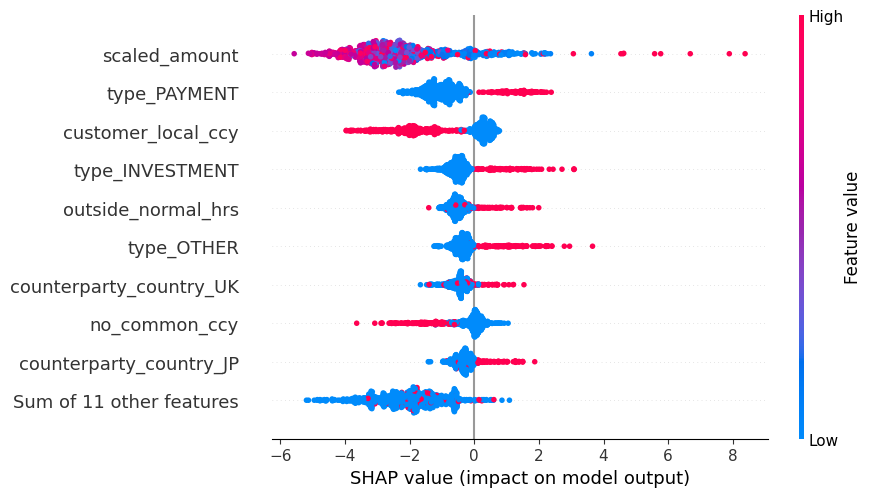

In [18]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

Overall, the scaled transaction amount is the most important feature in determining the probability of fraud followed by a transaction labeled 'Payment'. As scaled amount gets very high or very low it increases the liklihood of fraud. Being labeled as 'Payment' type increases the liklihood of fraud. The third biggest feature importance is whether the customer purchases in their local currency. If they do, it decreases the liklihood of fraud.

If I had more time, I would like to look at the impact of the categorical features as an aggregate (i.e. how much does the Type of transaction impact the prediction). 

I would also look into additional feature engineering such as the type of company the counter party is. Other potential features that may help improve the model could be including interaction terms such as customer - counterparty country combinations. The assumption I am making here would be that specific country combinations may have a greater impact on fraud than others. Lastly, one potential feature that may contribute to fraud is the frequency of transactions. If we categorize transaction activity by customer into low, medium, high levels of frequencies, and then calculate the time since their last transaction, it could be an indicator of fraudulent activity or lack of fraudulent activity.

Feature selection may improve the performance of the model as well as having fraud subject matter experts involved. 